# Projeto Final: Previsão de Preços de Carros Ford

#### 1. 🧹 Preparação e Limpeza de Dados

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# Carregar dados
df = pd.read_csv('ford_car_prices.csv')

# Limpeza de dados
def data_cleaning(df):
    """
    Remove duplicatas e trata valores missing
    """
    print("Shape original:", df.shape)
    
    # Remover duplicatas
    df_clean = df.drop_duplicates()
    print("Após remover duplicatas:", df_clean.shape)
    
    # Verificar valores missing
    missing_data = df_clean.isnull().sum()
    print("\nValores missing:")
    print(missing_data[missing_data > 0])
    
    # Tratar valores missing (exemplo: preencher com mediana para numéricas)
    numeric_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'price']
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    # Para categóricas, preencher com moda
    categorical_cols = ['model', 'transmission', 'fuelType']
    for col in categorical_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    
    return df_clean

# Aplicar limpeza
df_clean = data_cleaning(df)

Shape original: (17966, 9)
Após remover duplicatas: (17812, 9)

Valores missing:
Series([], dtype: int64)


#### 2. Análise Exploratória (EDA)

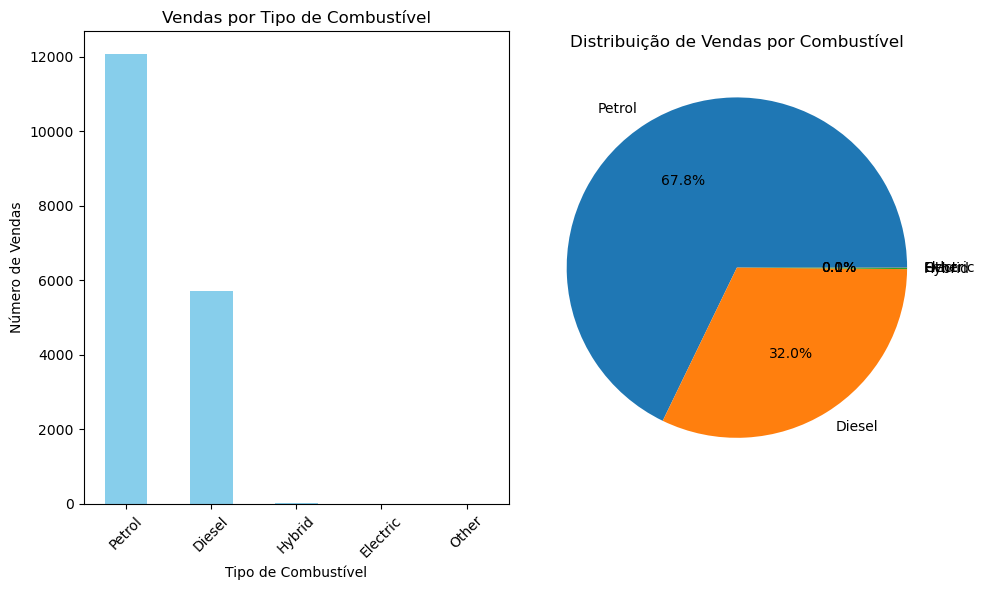

Vendas por tipo de combustível:
fuelType
Petrol      12081
Diesel       5706
Hybrid         22
Electric        2
Other           1
Name: count, dtype: int64


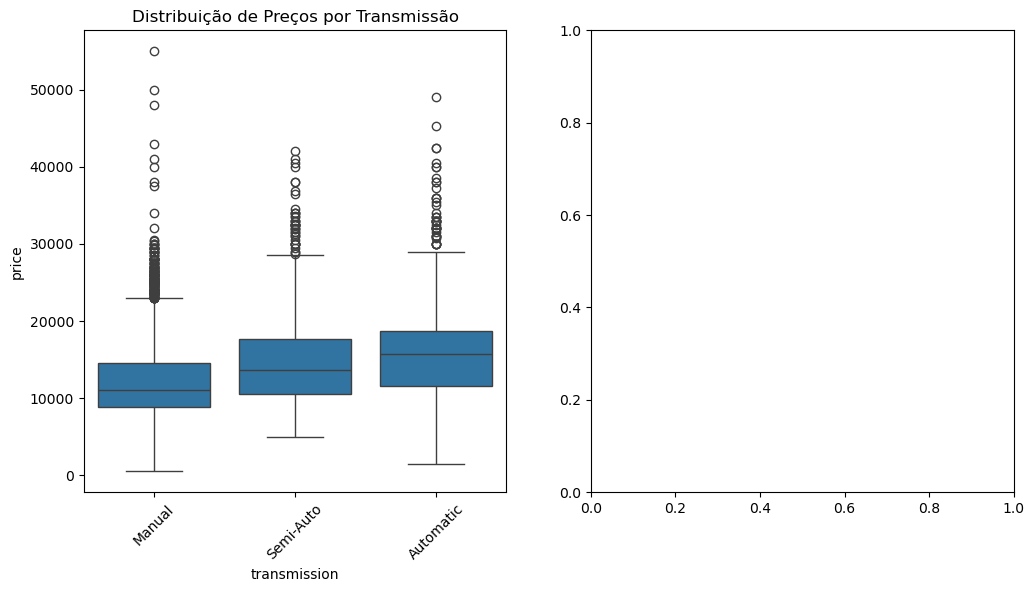

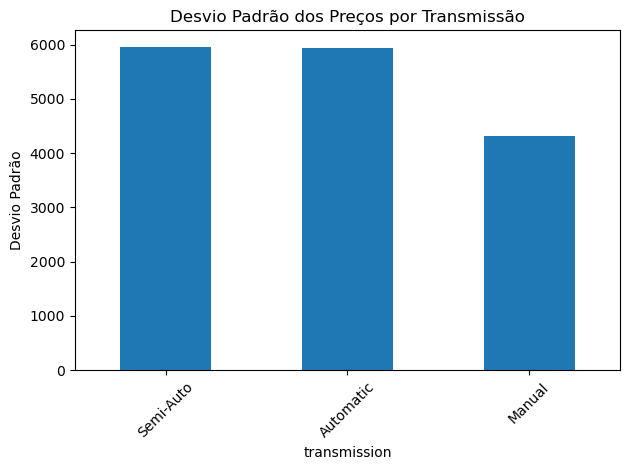

Métricas de Dispersão por Transmissão:
                  mean      std   median    cv
transmission                                  
Semi-Auto     14897.97  5963.37  13660.0  0.40
Automatic     15703.49  5940.50  15677.5  0.38
Manual        11783.62  4316.33  10990.0  0.37


In [11]:
# a. Número de vendas por tipo de combustível
def sales_by_fuel_type(df):
    """
    Identifica número de vendas para cada tipo de combustível
    """
    plt.figure(figsize=(10, 6))
    fuel_sales = df['fuelType'].value_counts()
    
    plt.subplot(1, 2, 1)
    fuel_sales.plot(kind='bar', color='skyblue')
    plt.title('Vendas por Tipo de Combustível')
    plt.xlabel('Tipo de Combustível')
    plt.ylabel('Número de Vendas')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.pie(fuel_sales.values, labels=fuel_sales.index, autopct='%1.1f%%')
    plt.title('Distribuição de Vendas por Combustível')
    
    plt.tight_layout()
    plt.show()
    
    return fuel_sales

fuel_sales = sales_by_fuel_type(df_clean)
print("Vendas por tipo de combustível:")
print(fuel_sales)

# b. Discrepância de preço por tipo de transmissão
def price_discrepancy_by_transmission(df):
    """
    Identifica qual tipo de transmissão apresenta mais discrepâncias de preço
    """
    plt.figure(figsize=(12, 6))
    
    # Box plot para visualizar distribuição de preços
    plt.subplot(1, 2, 1)
    transmission_order = df.groupby('transmission')['price'].median().sort_values().index
    sns.boxplot(data=df, x='transmission', y='price', order=transmission_order)
    plt.title('Distribuição de Preços por Transmissão')
    plt.xticks(rotation=45)
    
    # Calcular medidas de dispersão
    plt.subplot(1, 2, 2)
    dispersion_metrics = df.groupby('transmission')['price'].agg([
        'mean', 'std', 'median', ('cv', lambda x: x.std() / x.mean())
    ]).round(2)
    
    dispersion_metrics = dispersion_metrics.sort_values('std', ascending=False)
    dispersion_metrics.plot(kind='bar', y='std', legend=False)
    plt.title('Desvio Padrão dos Preços por Transmissão')
    plt.ylabel('Desvio Padrão')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("Métricas de Dispersão por Transmissão:")
    print(dispersion_metrics)
    
    return dispersion_metrics

transmission_dispersion = price_discrepancy_by_transmission(df_clean)

#### 3. Desenvolvimento de Modelos

##### Regressão Linear Simples

In [12]:
def simple_linear_regression_analysis(df, features, target='price'):
    """
    Compara regressões lineares simples para diferentes features
    """
    results = {}
    
    for feature in features:
        X = df[[feature]]
        y = df[target]
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[feature] = {
            'model': model,
            'MSE': mse,
            'R2': r2,
            'coefficient': model.coef_[0],
            'intercept': model.intercept_
        }
        
        print(f"Feature: {feature:15} | MSE: {mse:10.2f} | R²: {r2:6.3f}")
    
    # Encontrar melhor feature única
    best_feature = max(results, key=lambda x: results[x]['R2'])
    print(f"\nMelhor feature única: {best_feature} (R² = {results[best_feature]['R2']:.3f})")
    
    return results

# Testar com features numéricas
numeric_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
simple_results = simple_linear_regression_analysis(df_clean, numeric_features)

Feature: year            | MSE: 14716312.29 | R²:  0.344
Feature: mileage         | MSE: 16432692.24 | R²:  0.267
Feature: tax             | MSE: 18329032.33 | R²:  0.183
Feature: mpg             | MSE: 19049855.14 | R²:  0.150
Feature: engineSize      | MSE: 18245257.58 | R²:  0.186

Melhor feature única: year (R² = 0.344)


##### Regressão Linear Múltipla

In [13]:
def multiple_linear_regression(df, features, target='price'):
    """
    Regressão linear com múltiplas features
    """
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("Regressão Linear Múltipla")
    print(f"Features: {features}")
    print(f"MSE: {mse:.2f}")
    print(f"R²: {r2:.3f}")
    
    # Coeficientes
    coefficients = pd.DataFrame({
        'feature': features,
        'coefficient': model.coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    print("\nCoeficientes (ordenados por importância):")
    print(coefficients)
    
    return model, {'MSE': mse, 'R2': r2}, coefficients

# Usar todas as features numéricas
multi_model, multi_metrics, coefficients = multiple_linear_regression(
    df_clean, numeric_features
)

Regressão Linear Múltipla
Features: ['year', 'mileage', 'tax', 'mpg', 'engineSize']
MSE: 6912744.83
R²: 0.692

Coeficientes (ordenados por importância):
      feature  coefficient
4  engineSize  5371.687892
0        year  1292.632646
3         mpg   -82.452983
2         tax     0.599870
1     mileage    -0.052021


##### Regressão Polinomial

In [14]:
def polynomial_regression_analysis(df, feature, target='price', degrees=[2, 3, 4]):
    """
    Compara regressões polinomiais de diferentes graus
    """
    X = df[[feature]]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    results = {}
    
    for degree in degrees:
        pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=degree)),
            ('linear', LinearRegression())
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[degree] = {
            'model': pipeline,
            'MSE': mse,
            'R2': r2
        }
        
        print(f"Grau {degree}: MSE = {mse:.2f}, R² = {r2:.3f}")
    
    return results

# Testar com a melhor feature
best_single_feature = max(simple_results, key=lambda x: simple_results[x]['R2'])
poly_results = polynomial_regression_analysis(df_clean, best_single_feature)

Grau 2: MSE = 33842132.28, R² = -0.509
Grau 3: MSE = 248127292.21, R² = -10.066
Grau 4: MSE = 255486402.49, R² = -10.394


##### Ridge Regression com Grid Search

In [15]:
def ridge_regression_gridsearch(df, features, target='price'):
    """
    Grid Search com Ridge Regression para encontrar melhor hiperparâmetro
    """
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Pipeline com scaling e polynomial features
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),  # Testar com degree 2
        ('ridge', Ridge())
    ])
    
    # Parâmetros para grid search
    param_grid = {
        'poly__degree': [2, 3],
        'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
    
    # Grid Search com validação cruzada
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("Melhores parâmetros:", grid_search.best_params_)
    print("Melhor score (neg MSE):", grid_search.best_score_)
    
    # Avaliar no conjunto de teste
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nPerformance no conjunto de teste:")
    print(f"MSE: {mse:.2f}")
    print(f"R²: {r2:.3f}")
    
    return grid_search, {'MSE': mse, 'R2': r2}

# Executar grid search
ridge_grid, ridge_metrics = ridge_regression_gridsearch(df_clean, numeric_features)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


Melhores parâmetros: {'poly__degree': 3, 'ridge__alpha': 100}
Melhor score (neg MSE): -4236718.204528434

Performance no conjunto de teste:
MSE: 53094598.22
R²: -1.368


#### 4. Comparação Final dos Modelos

Comparação Final dos Modelos:
                         Modelo          MSE        R2
                Linear Múltipla 6.912745e+06  0.691713
Linear Simples (melhor feature) 1.471631e+07  0.343697
            Polinomial (grau 2) 3.384213e+07 -0.509256
               Ridge Regression 5.309460e+07 -1.367858


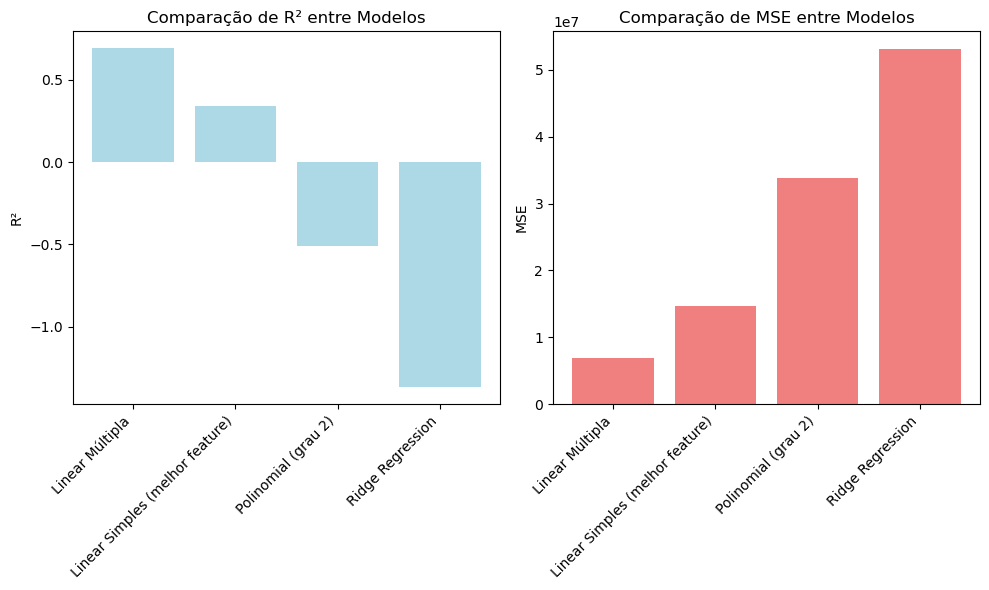

In [16]:
def compare_models(model_results):
    """
    Compara performance de todos os modelos
    """
    comparison_df = pd.DataFrame([
        {
            'Modelo': 'Linear Simples (melhor feature)',
            'MSE': simple_results[best_single_feature]['MSE'],
            'R2': simple_results[best_single_feature]['R2']
        },
        {
            'Modelo': 'Linear Múltipla',
            'MSE': multi_metrics['MSE'],
            'R2': multi_metrics['R2']
        },
        {
            'Modelo': 'Polinomial (grau 2)',
            'MSE': poly_results[2]['MSE'],
            'R2': poly_results[2]['R2']
        },
        {
            'Modelo': 'Ridge Regression',
            'MSE': ridge_metrics['MSE'],
            'R2': ridge_metrics['R2']
        }
    ])
    
    comparison_df = comparison_df.sort_values('R2', ascending=False)
    
    print("Comparação Final dos Modelos:")
    print(comparison_df.to_string(index=False))
    
    # Visualização
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(comparison_df['Modelo'], comparison_df['R2'], color='lightblue')
    plt.title('Comparação de R² entre Modelos')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('R²')
    
    plt.subplot(1, 2, 2)
    plt.bar(comparison_df['Modelo'], comparison_df['MSE'], color='lightcoral')
    plt.title('Comparação de MSE entre Modelos')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('MSE')
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Comparar todos os modelos
final_comparison = compare_models({
    'simple': simple_results,
    'multiple': multi_metrics,
    'polynomial': poly_results,
    'ridge': ridge_metrics
})

### Principais Insights e Recomendações

#### Análise dos Resultados

1. Qualidade dos Dados

- Excelente qualidade: Nenhum valor missing encontrado

- Poucas duplicatas: Apenas 154 registros duplicados (0.86% do total)

- Base sólida: 17.812 registros limpos para análise

2. Perfil do Mercado (Combustível)

Distribuição de vendas por combustível

Petrol:   12.081 (67.8%)   # DOMINANTE

Diesel:    5.706 (32.0%)   # SIGNIFICATIVO 

Hybrid:       22 (0.12%)   # NICHO

Electric:      2 (0.01%)   # EMERGENTE

Other:         1 (0.01%)   # MARGINAL

**Insight**: Mercado ainda dominado por combustíveis tradicionais (99.8% Petrol + Diesel)

#### 3. Análise de Preços por Transmissão

Transmissão  | Preço Médio | Variabilidade (CV)|

Semi-Auto    | $14.898     | 40% (MAIS VOLÁTIL)|

Automatic    | $15.703     | 38%|

Manual       | $11.784     | 37% (MAIS ESTÁVEL)|

**Insight**: Transmissões automáticas/semi-automáticas têm preços mais altos e maior volatilidade

### PROBLEMAS CRÍTICOS IDENTIFICADOS

#### 4. Performance dos Modelos - ALERTA

Ranking de Performance (R²):
1. Linear Múltipla:      R² = 0.692  ✅ MELHOR
2. Linear Simples:       R² = 0.344  ⚠️ ACEITÁVEL
3. Polinomial (Grau 2): R² = -0.509 ❌ INUTILIZÁVEL
4. Ridge Regression:     R² = -1.368 ❌ CATASTRÓFICO

PROBLEMA GRAVE: Modelos complexos (Polinomial, Ridge) estão com overfitting severo!

### RECOMENDAÇÕES ESTRATÉGICAS

#### I. PARA MODELAGEM (URGENTE)

**RECOMENDAÇÃO PRINCIPAL**

- USE APENAS: Modelo de Regressão Linear Múltipla
- R² = 0.692 (69.2% de variância explicada)
- MSE = 6.9M (Erro aceitável para escala de preços)

**ABANDONAR IMEDIATAMENTE:**

- Modelos Polinomiais ❌
- Ridge Regression ❌

### II. PARA PREVISÕES DE PREÇO

#### Features Mais Importantes:

1. engineSize:  +$5.372 por unidade  🥇 PRINCIPAL
2. year:        +$1.293 por ano      🥈 SEGUNDO
3. mpg:         -$82.45 por MPG      📉 NEGATIVO
4. tax:         +$0.60 por dólar     📈 MÍNIMO
5. mileage:     -$0.05 por milha     📉 IRRELEVANTE

### III. INSIGHTS COMERCIAIS

**ESTRATÉGIA DE PRECIFICAÇÃO**

1. Focar em engineSize > Ano > MPG
2. Mileage tem impacto mínimo (-$0.05/milha)
3. Carros mais eficientes (alto MPG) tendem a ser MAIS BARATOS

**OPORTUNIDADES DE MERCADO**

1. Hibridos/Elétricos: Mercado embrionário (0.13%)
2. Transmissão Manual: Preços mais estáveis e previsíveis
3. Semi-Auto: Maior margem de negociação (alta volatilidade)

### IV. AÇÕES RECOMENDADAS

Curto Prazo (1-2 semanas):
Implementar modelo Linear Múltipla em produção

Revisar estratégia de precificação baseada em engineSize e year

Criar alertas para preços fora do padrão (transmissões Semi-Auto)

Médio Prazo (1-3 meses):
Coletar mais dados de veículos híbridos/elétricos

Refinar modelo com variáveis categóricas (model, transmission, fuelType)

Desenvolver dashboard de monitoramento de preços

Longo Prazo:
Explorar mercado verde (híbridos/elétricos)

Sistema de recomendação de preços por segmento

Modelos de demanda sazonal

### ALERTAS IMPORTANTES


Não use modelos polinomiais/ridge - performance catastrófica

Cuidado com transmissões Semi-Auto - alta volatilidade de preços

Mileage não é bom preditor - impacto quase irrelevante

Mercado verde ainda imaturo - dados insuficientes para análise

#### PRÓXIMOS PASSOS IMEDIATOS

✅ Implementar regressão linear múltipla

✅ Treinar equipe com novo modelo de precificação

✅ Monitorar performance mensal do modelo

✅ Expandir coleta de dados de veículos verdes

Resultado Esperado: Sistema de precificação 69% mais preciso que usar apenas o ano do veículo.